<h1><center>Capstone Project: Segmenting and Clustering Neighborhoods in Toronto</center></h1>
<h3><center>Clustering</center></h3>
<h4>About this Notebook</h4>
<br>created by <a href="https://github.com/Sherryl93/">@Sherryl93</a>

<br>
<br> Data Source: 
<br>- <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M</a>
<br>- <a href="http://cocl.us/Geospatial_data">http://cocl.us/Geospatial_data</a>

In [54]:
#Libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [3]:
# fetch data from wikipedia and parse the HTML/XML 
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
# extracting the raw table inside that webpage
table = soup.find('table')

## Extract data from Raw Table

In [4]:
#Declare empty list
postal_list   = []
borough_list  = []
neighbor_list = []


# begin loop to fetch data 
for tr_cell in table.find_all('tr'):
    for td_cell in tr_cell.find_all('td'):
        #print(td_cell)
        # loop trhough postal:
        for b in td_cell.find_all('b'):
            postal_list.append(b.string)
        if not(td_cell.find_all('i') or td_cell.find_all('a')):
            str1,str2 = td_cell.find('span',{'style':'font-size:80%;'}).text.replace(')', '').split('(')
            borough_list.append(str1)
            neighbor_list.append(str2)
        elif td_cell.find_all('i'):
            for i in td_cell.find_all('i'):
                borough_list.append(i.string)
            neighbor_list.append(None)
        else:
            counter = 0
            temp_neigh  = [] #for temp only
            for a in td_cell.find_all('a'):
                #print(a.get('title'))
                if counter == 0:
                    borough_list.append(a.string)
                    #print(a.string)
                    counter+=1
                else:
                    temp_neigh.append(a.string)
            if len(temp_neigh)>1:
                neighbor_list.append(','.join(temp_neigh))
            else:
                try:
                    neighbor_list.append(temp_neigh[0])
                except:
                    neighbor_list.append(None)
                    
# integrate
data = {'PostalCode': postal_list, 'Borough': borough_list, 'Neighborhood':neighbor_list}
df = pd.DataFrame.from_dict(data)

#Drop column if column contained not assigned
df_cleaned = df[(df.Borough != 'Not assigned')& (df.Borough.notna()) & (df.Neighborhood.notna())]
df_cleaned.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park,Harbourfront"
5,M6A,North York,"Lawrence Manor,Lawrence Heights"
6,M7A,Queen's Park,Ontario Provincial Government


In [6]:
 #geo df
url="http://cocl.us/Geospatial_data"
geo_df=pd.read_csv(url)
geo_df = geo_df.rename(columns={"Postal Code": "PostalCode"})
df_geo = pd.merge(df_cleaned, geo_df, on='PostalCode')
df_geo.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park,Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor,Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [13]:
df_geo.columns.tolist()

['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']

In [14]:
neighborhoods = df_geo[df_geo.columns.tolist()[1:]]
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park,Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor,Lawrence Heights",43.718518,-79.464763
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [16]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        len(neighborhoods['Neighborhood'].unique())
        #neighborhoods.shape[0]
    )
)

The dataframe has 20 boroughs and 86 neighborhoods.


In [17]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [21]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


Solving environment: done

# All requested packages already installed.



### Use geopy library to get the latitude and longitude values of Torronto

In [27]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Torronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Torronto are 43.653963, -79.387207.


In [29]:

# create map of New York using latitude and longitude values
map_torronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_torronto)  
    
map_torronto

In [30]:

CLIENT_ID = '*****' # your Foursquare ID
CLIENT_SECRET = '***' # your Foursquare Secret
VERSION = '20200320' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PLAS1TXKCBAJBTFBTZV2OGB0JQTHH5LNCQZJKUW2A4RWHHFS
CLIENT_SECRET:K44IMOMSED230PFSIRNSRTHR4OEA2REEKLSGUMORTSQY1VIR


### Analyze Torronto Neighborhood

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
radius = 400 #within 400 radius
LIMIT = 50 # this will retreive data for only 100 venues per neighbourhood
nearby_venues = getNearbyVenues(names = df_geo['Neighborhood'], latitudes = df_geo['Latitude'], longitudes = df_geo['Longitude'])

Parkwoods
Victoria Village
Regent Park,Harbourfront
Lawrence Manor,Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern,Rouge
Don Mills
Parkview Hill,Woodbine Gardens
Garden District,Ryerson
West Deane Park,Princess Gardens,Martin Grove,Islington
Rouge Hill,Port Union,Highland Creek
Don Mills,Flemingdon Park
Woodbine Heights
St. James Town
Humewood-Cedarvale
Markland Wood
Guildwood,Morningside,West Hill
Caledonia-Fairbanks
Woburn
Leaside
Bay Street
Cedarbrae
Hillcrest Village
Bathurst Manor,Wilson Heights,Downsview
Thorncliffe Park
Richmond,King
Dovercourt Village
Scarborough Village
Henry Farm
Northwood Park,York University
The Danforth
Harbourfront,Union Station,Toronto Islands
Trinity
Kennedy Park,Ionview,Birchmount Park
Bayview Village
Downsview,CFB Toronto
Riverdale
Toronto Dominion Centre,Design Exchange
Parkdale Village,Exhibition Place
Golden Mile,Clairlea,Oakridge
York Mills
Downsview
The Beaches
Commerce Court,Victoria Hotel
Maple Leaf Park
Humber Summit
Cl

In [41]:
print("venues shape:", nearby_venues.shape)
nearby_venues.head()

venues shape: (1466, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [43]:
print('There are {} uniques Neighborhood.'.format(len(nearby_venues['Neighborhood'].unique())))
print('There are {} uniques venue categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 83 uniques Neighborhood.
There are 243 uniques venue categories.


In [47]:
# one hot encoding
torronto_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
torronto_onehot['Neighborhood'] = nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [torronto_onehot.columns[-1]] + list(torronto_onehot.columns[:-1])
torronto_onehot = torronto_onehot[fixed_columns]

print(torronto_onehot.shape)
torronto_onehot.head()

(1466, 243)


,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
torronto_grouped = torronto_onehot.groupby('Neighborhood').mean().reset_index()
print(torronto_grouped.shape)
torronto_grouped.head(10)

(83, 243)


,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,"Alderwood,Long Branch",0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,"Bathurst Manor,Wilson Heights,Downsview",0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,Bay Street,0.02,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,...,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,Bayview Village,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5,"Bedford Park,Lawrence Manor",0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
6,"Birch Cliff,Cliffside",0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7,"CN Tower,King and Spadina,Railway Lands,Harbou...",0.00,0.0,0.071429,0.071429,0.071429,0.142857,0.142857,0.071429,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
8,Caledonia-Fairbanks,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.25
9,Cedarbrae,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [51]:
print("print each neighborhood along with the top 5 most common venues")
num_top_venues = 5

for hood in torronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = torronto_grouped[torronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

print each neighborhood along with the top 5 most common venues
----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1               Skating Rink   0.2
2             Breakfast Spot   0.2
3                     Lounge   0.2
4             Clothing Store   0.2


----Alderwood,Long Branch----
          venue  freq
0   Pizza Place  0.22
1  Skating Rink  0.11
2          Pool  0.11
3           Gym  0.11
4      Pharmacy  0.11


----Bathurst Manor,Wilson Heights,Downsview----
                 venue  freq
0                 Bank  0.11
1          Coffee Shop  0.11
2  Fried Chicken Joint  0.05
3        Deli / Bodega  0.05
4       Sandwich Place  0.05


----Bay Street----
                venue  freq
0         Coffee Shop  0.18
1  Italian Restaurant  0.06
2     Bubble Tea Shop  0.04
3      Ice Cream Shop  0.04
4  Chinese Restaurant  0.04


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2   Chinese Restau

In [52]:
# A function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
# create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = torronto_grouped['Neighborhood']

for ind in np.arange(torronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(torronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Latin American Restaurant,Clothing Store,Breakfast Spot,Lounge,Women's Store,Dance Studio,Donut Shop,Dog Run,Distribution Center
1,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Gym,Sandwich Place,Skating Rink,Pool,Pharmacy,Pub,Comfort Food Restaurant,Cupcake Shop
2,"Bathurst Manor,Wilson Heights,Downsview",Bank,Coffee Shop,Diner,Sushi Restaurant,Ice Cream Shop,Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Middle Eastern Restaurant
3,Bay Street,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Ice Cream Shop,Chinese Restaurant,Bubble Tea Shop,Japanese Restaurant,Ramen Restaurant,Hotel,Seafood Restaurant
4,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Women's Store,Diner,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store


## Cluster Toronto Neighborhoods

In [58]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline 

# data 
torronto_grouped_clustering = torronto_grouped.drop('Neighborhood', 1)

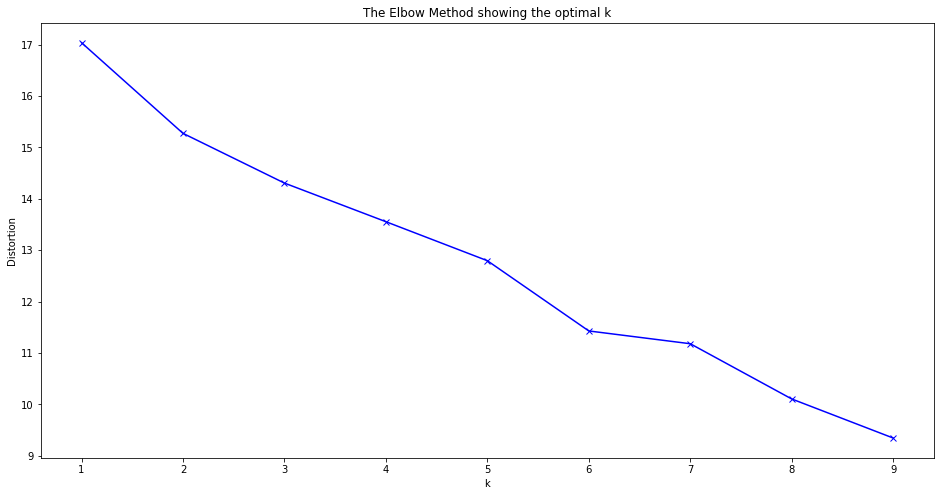

In [59]:
## APPLY ELBOW METHOD FOR K MEANS CLUSTER
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(torronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [60]:
# set number of clusters
kclusters = 6


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(torronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 2, 3], dtype=int32)

In [67]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [70]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

torronto_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
torronto_merged = torronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

torronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Food & Drink Shop,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant
1,North York,Victoria Village,43.725882,-79.315572,3.0,Coffee Shop,Hockey Arena,Portuguese Restaurant,Financial or Legal Service,Women's Store,Dim Sum Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner
2,Downtown Toronto,"Regent Park,Harbourfront",43.654260,-79.360636,3.0,Coffee Shop,Bakery,Pub,Park,Café,Theater,Restaurant,Mexican Restaurant,Chocolate Shop,Performing Arts Venue
3,North York,"Lawrence Manor,Lawrence Heights",43.718518,-79.464763,3.0,Clothing Store,Accessories Store,Boutique,Coffee Shop,Miscellaneous Shop,Event Space,Furniture / Home Store,Vietnamese Restaurant,Shoe Store,Dog Run
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,3.0,Coffee Shop,Park,Yoga Studio,Distribution Center,Beer Bar,Seafood Restaurant,Italian Restaurant,Sandwich Place,Burger Joint,Burrito Place


In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(torronto_merged['Latitude'], torronto_merged['Longitude'], torronto_merged['Neighborhood'], torronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters